# Classification - Titanic data set

In [10]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In this notebook we will use dataset from the titanic.


Each entry in the dataset has the following features: 

-  item class (1st, 2nd,...)
-  item Age (float)
-  Sex (Male /Female)


We will try to predict for evey entry if it describes a pearson who survived or not.

Fist, read the dataset and clean:

In [11]:
data = pd.read_csv('./Titanic.csv')[["PClass","Age","SexCode","Survived"]]

data = data.dropna(how='any')
mapper = {'1st':1, '2nd':2,'3rd':3}
data = data[data['PClass'].isin(mapper.keys())]
data['PClass'] = list(map( lambda v: mapper[v], data['PClass'].values))
data.loc[data.Survived == 0, 'Survived'] = -1

X = np.asmatrix(data.drop('Survived', axis=1))
y = np.asmatrix(data['Survived']).T
data.head()


,PClass,Age,SexCode,Survived
0,1,29.00,1,1
1,1,2.00,1,-1
2,1,30.00,0,-1
3,1,25.00,1,-1
4,1,0.92,0,1


*Recall*: Given $X\in \mathbb{R}^{n\times p}$ a dataset with $n$ examples and $p$ features, and $y\in \mathbb{R}^n$ the output we want to predict/fit.

we want to learn a function 
$f:\mathbb{R}^{n\times p}\rightarrow \mathbb{R}^n$ s.t. 
$||f\left( X\right) - y||$ is minimized.

We will use linear predictor for this task, i.e. we'll try to solve:
$ \min_{\theta} ||X \theta -y|| $

And use the optimized $\theta^*$ to define our predictor $f(x) = sign(\theta^Tx)$

We'll use the simplest model: $f\left(x\right)=\sum\theta_{i}x_{i}=x^{T}\theta$
And yry to minimize it's square loss:

Finding the optimal solution is given by the following closed form:
$\theta^{*}=\left(X^{T}X\right)^{-1}X^{T}y$

In [12]:
w = np.linalg.inv(X.T * X) * X.T *y
w

matrix([[-0.23918534],
        [-0.00362094],
        [ 1.09258828]])

Lets check accuracy:

In [13]:
yhat = X*w
np.sum(np.multiply(yhat, y)>0)/y.size

0.77910052910052907

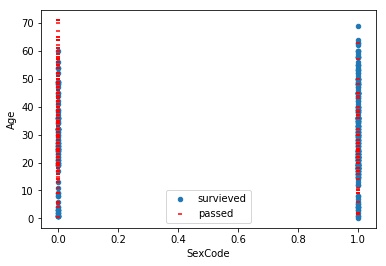

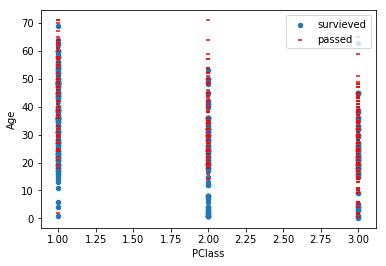

In [14]:
ax = data[y>0].plot(kind='scatter', x="SexCode",y="Age", label='survieved')
data[y<=0].plot(kind='scatter', x="SexCode",y="Age", color='red', marker='_', label='passed', ax=ax)

ax = data[y>0].plot(kind='scatter', x="PClass",y="Age", label='survieved')
data[y<=0].plot(kind='scatter', x="PClass",y="Age", color='red', marker='_', label='passed', ax=ax)


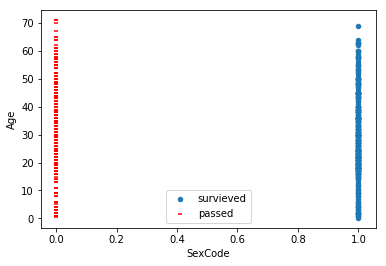

In [15]:
ax = data[yhat>0].plot(kind='scatter', x="SexCode",y="Age", label='survieved')
data[yhat<=0].plot(kind='scatter', x="SexCode",y="Age", color='red', marker='_', label='passed', ax=ax)


Notice that we achieved the optimal solution,
but it is optimal w.r.t $\ell_2$ norm, 
does it make sense to try linear fitting on a classification task?

Lets try different approach, define convex optimization which will
find a function $f$ which might make more sense.

We can solve the problem exactly by formulating:

\begin{align*}
\min_{w}.\quad & 0\\ 
s.t.\quad & -y^{i}\left\langle x^{i},w\right\rangle \leq0,\forall i\in\left[n\right]
\end{align*}

But the LS didn't manage to separate the data and thus the data
is not lineary seperable, and thus the above optimization will return $-\infty$.

So we need to drop constraints:
\begin{align*}
\min_{w}.\quad & \sum_{i}\boldsymbol{1}_{y^{i}\left\langle x^{i},w\right\rangle \geq0}
\end{align*}

*BUT* the above formulation is not a convex problem.
we'll solve this issue by minimizing a function which is an upper bound of the previous unconvex problem, but this one will be a convex optimization problem:

\begin{align*}
\min_{w}.\quad & \sum_{i}\max\left\{ 0,1-y^{i}\left\langle x^{i},w\right\rangle \right\}
\end{align*}

In [16]:
def objective(w):
    return np.sum(np.maximum(1- np.multiply(y, X*w).T, np.zeros(y.size)))

def gradient(w):
    g_i = np.array(np.multiply(y, X*w) <= 1).flatten()
    return X[g_i].T * y[g_i]
    
w = np.random.normal(0,100,3).reshape(3,1)

eps = 1e-5
objective(w)

612351.57867828873

Now we can finally use GD to solve the problem.
For this task, backtracking is sufficient for quick convergance.

In [17]:
def backtrack(w, g):
    t=1
    g_norm = g.T*g
    base_eval = objective(w)
    while objective(w+t*g)> (base_eval - 0.1*t*g_norm):
        t /= 2
    return t

t=1
i=0
while t>eps:
    g = gradient(w)
    t = backtrack(w, g)
    w += t*g
    
    if i % 100 == 0:
        print(np.sum(np.multiply(X*w, y)>0)/y.size)
        print(i)
    i+=1
print(np.sum(np.multiply(X*w, y)>0)/y.size)
print(i)

0.585978835979
0
0.588624338624
100
0.593915343915
200
0.599206349206
300
0.617724867725
400
0.640211640212
500
0.667989417989
600
0.73544973545
700
0.756613756614
749


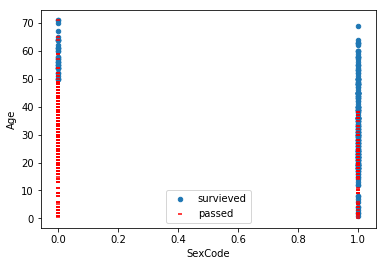

In [18]:
yhat = X*w
ax = data[yhat>0].plot(kind='scatter', x="SexCode",y="Age", label='survieved')
data[yhat<=0].plot(kind='scatter', x="SexCode",y="Age", color='red', marker='_', label='passed', ax=ax)


Notice that the accuracy is almost the same, but the 
partitioning is done differently.